https://github.com/itmo-ml-lab-ML-course/parser-denx24x/pull/2

Из первого задания я допарсил минимальную цену на телефон

Получился датасет из почти тысячи записей.


In [ ]:
import pandas as pd
df = pd.read_csv('output.csv', sep=";")
for i in ['CPU cores', 'RAM']:
  df[i] = pd.to_numeric(df[i])
for i in ['Diagonal', 'Width', 'Height']:
  df[i] = df[i].replace(',', '.', regex=True).astype(float)
for i in ['OS', 'Producer', 'CPU cores', 'RAM', 'Diagonal', 'Width', 'Height']:
  print(i)
  print(*sorted(df[i].unique()), sep=' ; ')
  print()

OS
Android 10,0 ; Android 11 ; Android 12 ; Android 13 ; Android 14 ; Android 9,0 Pie ; HarmonyOS 2,0 ; HarmonyOS 3,0 ; HarmonyOS 3,1 ; HarmonyOS 4,0 ; iOS 13 ; iOS 14 ; iOS 16 ; iOS 17

Producer
AGM ; Apple ; Asus ; Blackview ; Conquest ; Coolpad ; Cubot ; Doogee ; F150 ; FOSSiBOT ; Google ; HTC ; HiSense ; Honor ; Hotwav ; Huawei ; Infinix ; LG ; Lenovo ; Motorola ; Nokia ; Nothing ; OnePlus ; Oppo ; Oukitel ; POCO ; Realme ; Samsung ; Sony ; TCL ; Tecno ; UMIDIGI ; Ulefone ; Unihertz ; Vivo ; Wiko ; Xiaomi ; ZTE ; iiiF150 ; itel ; nubia

CPU cores
4 ; 6 ; 8 ; 9

RAM
1 ; 2 ; 3 ; 4 ; 6 ; 8 ; 12 ; 16 ; 18

Diagonal
3.0 ; 3.5 ; 4.0 ; 4.2 ; 4.3 ; 4.5 ; 4.7 ; 5.0 ; 5.2 ; 5.3 ; 5.45 ; 5.5 ; 5.65 ; 5.7 ; 5.71 ; 5.81 ; 5.84 ; 5.86 ; 5.9 ; 5.92 ; 5.93 ; 5.99 ; 6.0 ; 6.09 ; 6.1 ; 6.15 ; 6.18 ; 6.2 ; 6.21 ; 6.22 ; 6.24 ; 6.26 ; 6.28 ; 6.3 ; 6.34 ; 6.35 ; 6.36 ; 6.38 ; 6.39 ; 6.4 ; 6.43 ; 6.44 ; 6.45 ; 6.46 ; 6.47 ; 6.49 ; 6.5 ; 6.51 ; 6.52 ; 6.53 ; 6.54 ; 6.55 ; 6.56 ; 6.57 ; 6.58 ; 6.59 ; 6.6 

## Проверим данные на наличие выбросов

Построим boxplot для каждого столбца


CPU cores


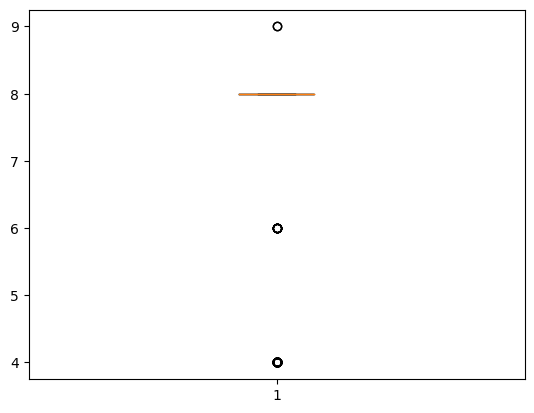

RAM


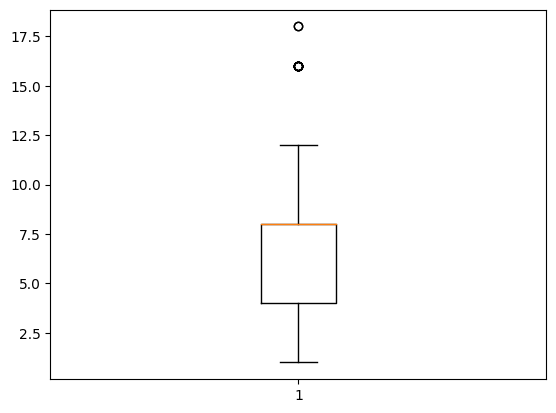

Diagonal


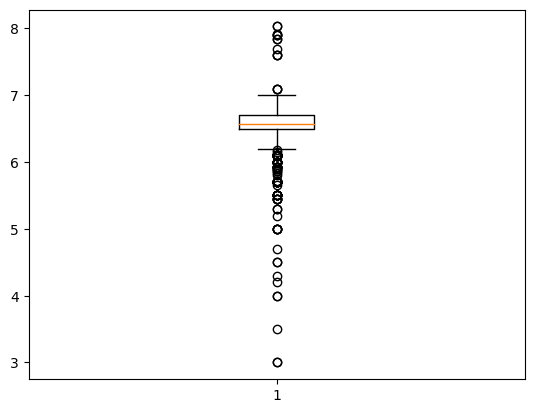

Width


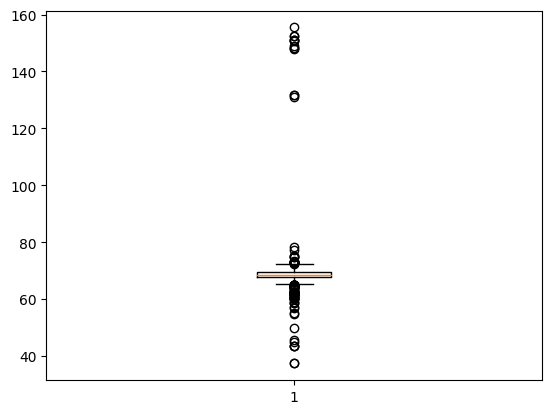

Height


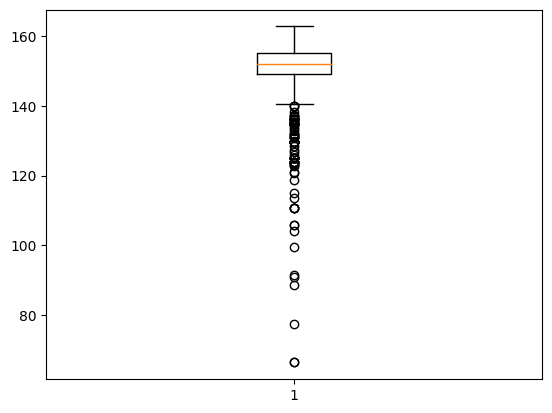

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

for i in ['CPU cores', 'RAM', 'Diagonal', 'Width', 'Height']:
  print(i)
  plt.boxplot(df[i])
  plt.show()

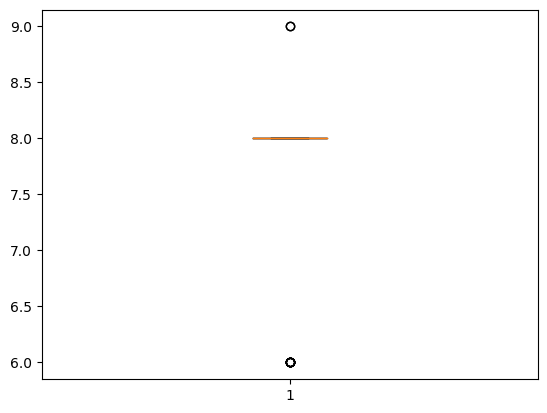

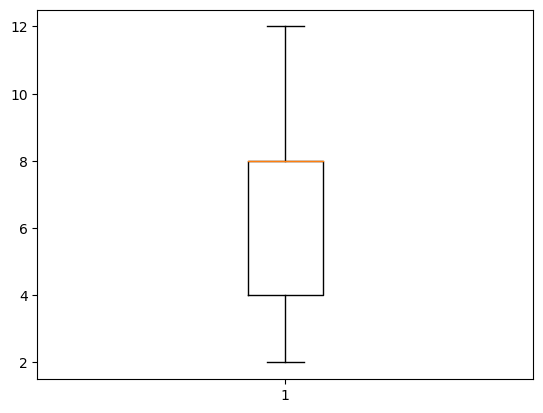

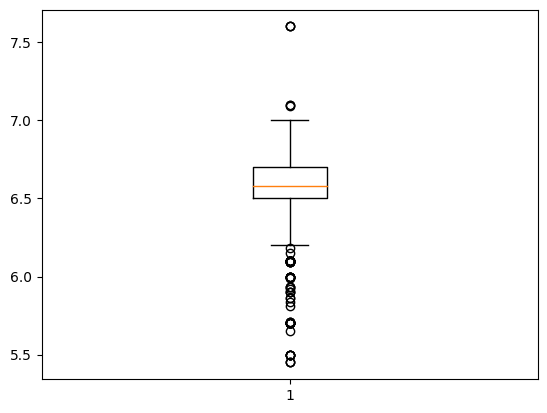

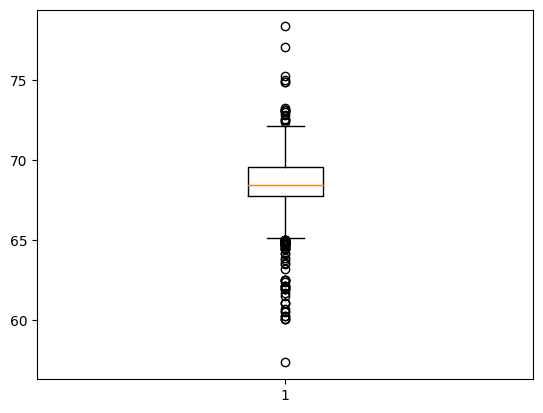

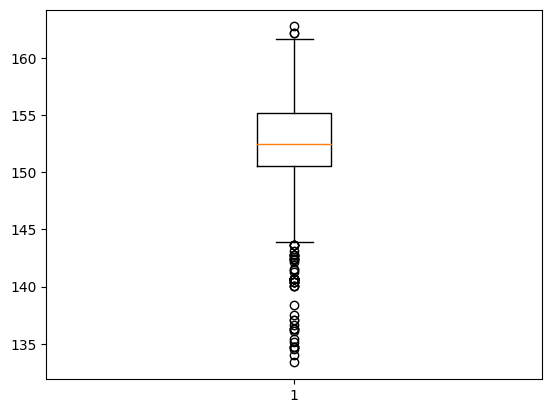

In [ ]:



for i in ['CPU cores', 'RAM', 'Diagonal', 'Width', 'Height']:
  df = df[(np.abs(scipy.stats.zscore(df[i])) < 3 )]
  plt.boxplot(df[i])
  plt.show()

## Выполним преобразование onehot для категориальных признаков



In [ ]:

converted_df = pd.get_dummies(df, columns=['OS', 'Producer'])
print(converted_df.head())

   RAM  CPU cores  Diagonal  Width  Height   Price  OS_Android 10,0  \
0    6          8      6.52  67.96  151.02   16555                0   
1   12          8      6.58  68.40  152.50  113820                0   
2    4          8      5.93  67.36  134.72   22777                0   
3    8          8      6.74  69.91  156.27   20605                0   
4   12          9      6.71  69.84  155.47  101432                0   

   OS_Android 11  OS_Android 12  OS_Android 13  ...  Producer_Tecno  \
0              0              0              1  ...               0   
1              0              0              1  ...               0   
2              0              0              1  ...               0   
3              0              0              1  ...               0   
4              0              0              0  ...               0   

   Producer_UMIDIGI  Producer_Ulefone  Producer_Unihertz  Producer_Vivo  \
0                 0                 1                  0              0

In [ ]:
import sklearn

## Выберем по одному методу из каждой категории:

### Ближайшего соседа.

sklearn.neighbors.KNeighborsRegressor

### Линейной.

sklearn.linear_model.Ridge

### Деревья принятия решений.

sklearn.tree.DecisionTreeRegressor

### Ансамбль.

sklearn.ensemble.ExtraTreesRegressor


## Выберем функцию качества или ошибки

Это будет MAPE

In [ ]:
def error(expected, result):
  return sklearn.metrics.mean_absolute_percentage_error(expected, result)

## Разделим данные

Получим train, valid, test датасеты.

train будет занимать 80% изначального датасета

valid и test - по 10%.

In [ ]:
import sklearn.preprocessing

scaler = sklearn.preprocessing.StandardScaler()
ln = converted_df.shape[0]
print(ln)
print(int(ln * 0.8), int(ln * 0.1), int(ln * 0.1))
converted_df = converted_df.sample(frac=1).reset_index(drop=True)
train = converted_df[:int(ln * 0.8)]
train_x = scaler.fit_transform(train.drop(columns=['Price']))
train_y = train['Price']
valid = converted_df[int(ln * 0.8):int(ln * 0.9)]
valid_x = scaler.transform(valid.drop(columns=['Price']))
valid_y = valid['Price']
test = converted_df[int(ln * 0.9):ln]
test_x = scaler.transform(test.drop(columns=['Price']))
test_y = test['Price']

829
663 82 82


## Метод ближайшего соседа

Ищет K ближайших соседей, возвращает среднее их значений

Рассматриваем гиперпараметр числа соседей

train


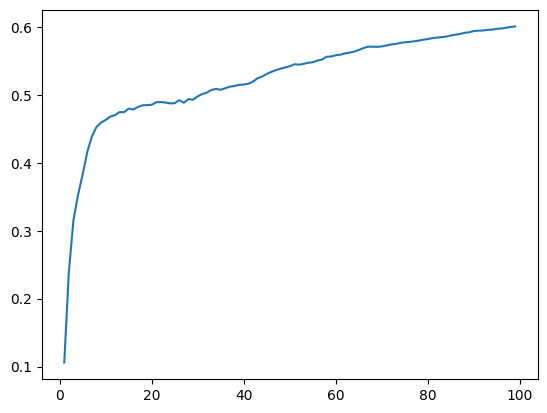

valid


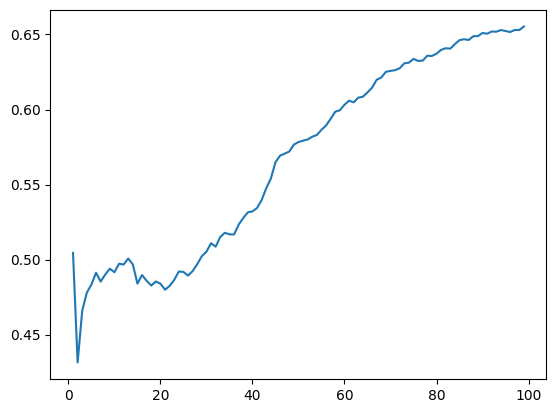

test


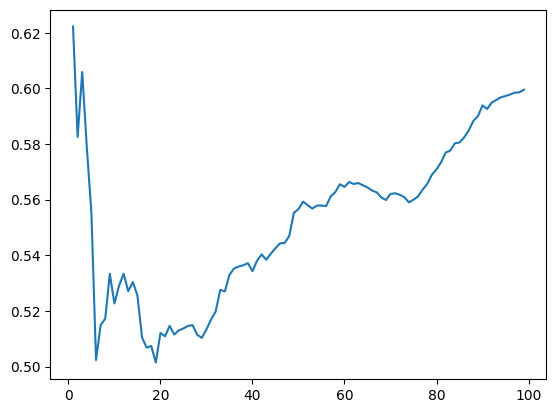

In [ ]:
import sklearn.neighbors

labels = ['train', 'valid', 'test']
datas = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
graph_data = [[], [], []]
for neighbors in range(1, 100):
  model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=neighbors)
  fitted = model.fit(train_x, train_y)
  for i in range(len(datas)):
    result = fitted.predict(datas[i][0])
    graph_data[i].append((neighbors, error(datas[i][1], result)))
for i in range(len(graph_data)):
  print(labels[i])
  plt.plot([i[0] for i in graph_data[i]],[i[1] for i in graph_data[i]])
  plt.show()

Как видно, метод работает значительно хуже с увеличением числа рассматриваемых соседей. (Что, вроде как, логично)
Достигает определенной точности на train датасете при малом числе соседей, на данных не из датасета результат плохой.

## Метод линейной регрессии

Ищем похожую прямую, дополнительно имеем регуляризацию

Рассматриваем гиперпарамер регуляризации

train


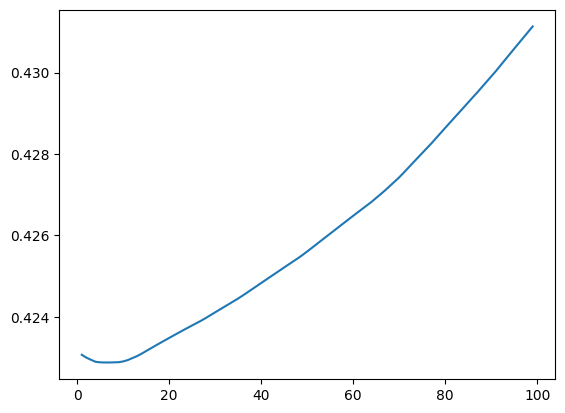

valid


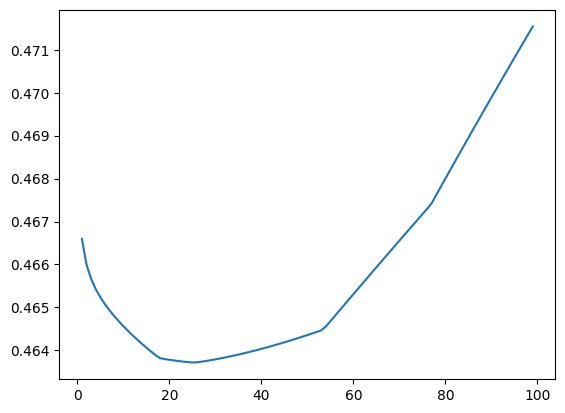

test


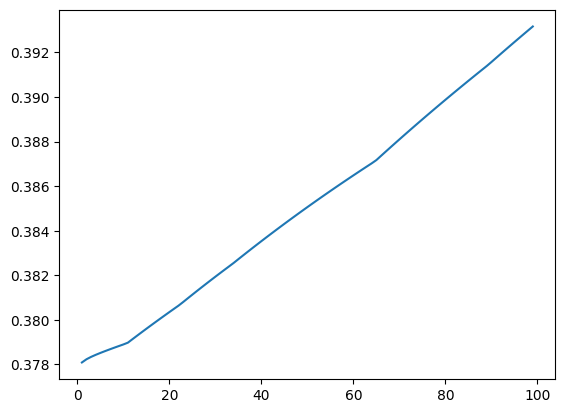

In [ ]:
labels = ['train', 'valid', 'test']
datas = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
graph_data = [[], [], []]
for a in range(1, 100):
  model = sklearn.linear_model.Ridge(alpha=a)
  fitted = model.fit(train_x, train_y)
  for i in range(len(datas)):
    result = fitted.predict(datas[i][0])
    graph_data[i].append((a, error(datas[i][1], result)))
for i in range(len(graph_data)):
  print(labels[i])
  plt.plot([i[0] for i in graph_data[i]],[i[1] for i in graph_data[i]])
  plt.show()

##  Деревья принятия решений

Рассматриваем гиперпараметр максимальной глубины дерева


train


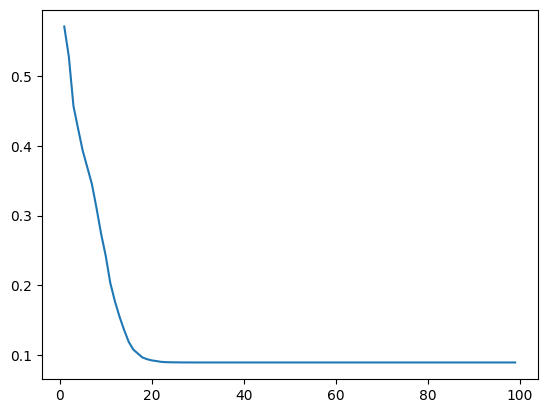

valid


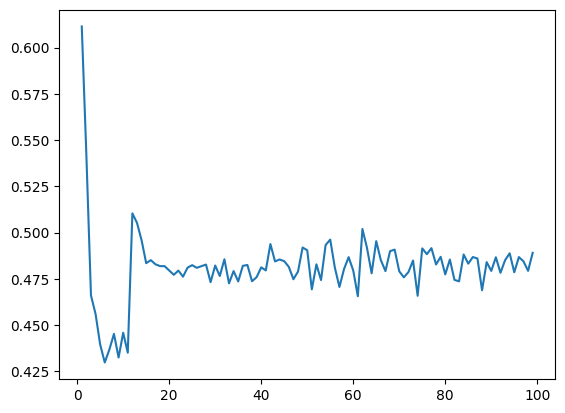

test


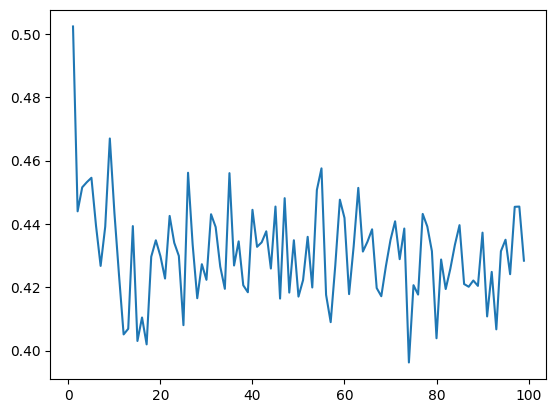

In [ ]:
import sklearn.tree

labels = ['train', 'valid', 'test']
datas = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
graph_data = [[], [], []]
for d in range(1, 100):
  model = sklearn.tree.DecisionTreeRegressor(max_depth=d)
  fitted = model.fit(train_x, train_y)
  for i in range(len(datas)):
    result = fitted.predict(datas[i][0])
    graph_data[i].append((d, error(datas[i][1], result)))
for i in range(len(graph_data)):
  print(labels[i])
  plt.plot([i[0] for i in graph_data[i]],[i[1] for i in graph_data[i]])
  plt.show()

## Ансамбль

Лес деревьев принятия решений

Рассматриваем гиперпараметр числа деревьев (глубину ограничим в 20)

train


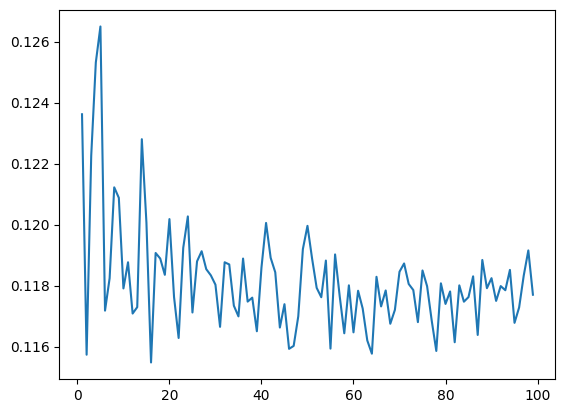

valid


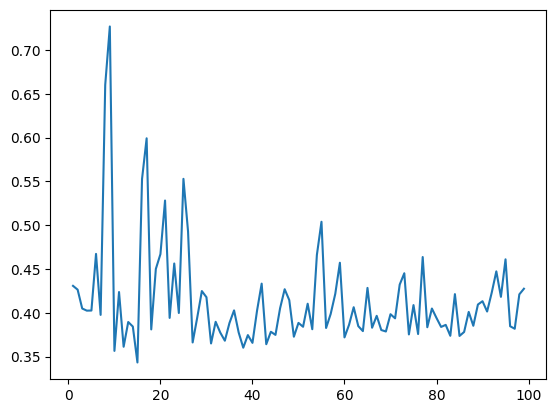

test


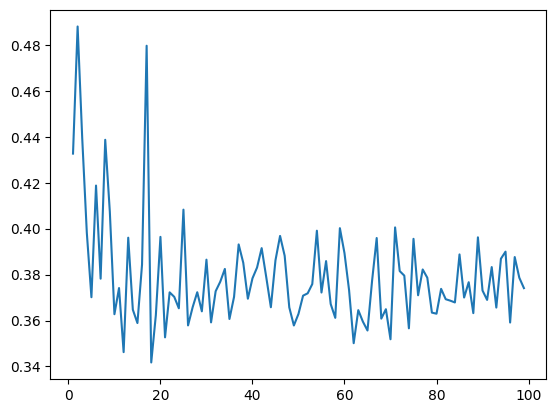

In [ ]:
import sklearn.ensemble

labels = ['train', 'valid', 'test']
datas = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
graph_data = [[], [], []]
for d in range(1, 100):
  model = sklearn.ensemble.ExtraTreesRegressor(n_estimators=d, max_depth=20)
  fitted = model.fit(train_x, train_y)
  for i in range(len(datas)):
    result = fitted.predict(datas[i][0])
    graph_data[i].append((d, error(datas[i][1], result)))
for i in range(len(graph_data)):
  print(labels[i])
  plt.plot([i[0] for i in graph_data[i]],[i[1] for i in graph_data[i]])
  plt.show()